(180, 180)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


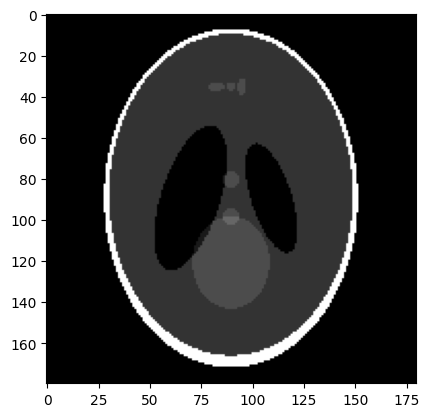

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan
from scipy import ndimage
from scipy.signal import convolve
from skimage.transform import radon

### 1. 生成模拟物体模型
N = 180
phantom = shepp_logan(N) 
print(phantom.shape)
print(phantom)

plt.imshow(phantom, cmap='gray')
plt.show()


Text(0.5, 1.0, '180° Parallel Beam Projection')

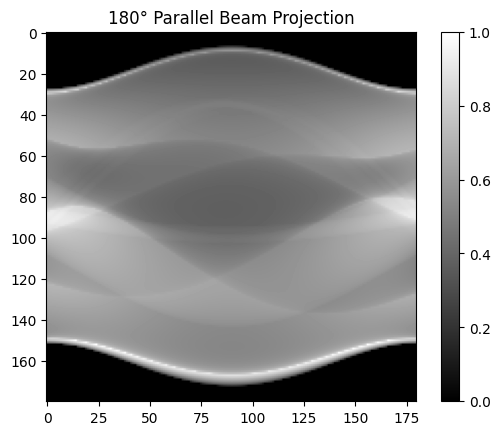

In [2]:
###2.1  创建Shepp-Logan phantom的投影数据
# 用矩阵表示物体的密度分布，每个像素点的值代表该点的密度。
def forward_projection(theta_proj, N, N_d):
    shep = np.array( #定义 Shepp-Logan Phantom 参数
        [
            [1, 0.69, 0.92, 0, 0, 0],
            [-0.8, 0.6624, 0.8740, 0, -0.0184, 0],
            [-0.2, 0.1100, 0.3100, 0.22, 0, -18],
            [-0.2, 0.1600, 0.4100, -0.22, 0, 18],
            [0.1, 0.2100, 0.2500, 0, 0.35, 0],
            [0.1, 0.0460, 0.0460, 0, 0.1, 0],
            [0.1, 0.0460, 0.0460, 0, 0.1, 0],
            [0.1, 0.0460, 0.0230, -0.08, -0.605, 0],
            [0.1, 0.0230, 0.0230, 0, -0.606, 0],
            [0.1, 0.0230, 0.0460, 0.06, -0.605, 0],
        ]
    )
    # 初始化变量
    theta_num = len(theta_proj)
    P = np.zeros((int(N_d), theta_num))
    rho = shep[:, 0]
    ae = 0.5 * N * shep[:, 1]
    be = 0.5 * N * shep[:, 2]
    xe = 0.5 * N * shep[:, 3]
    ye = 0.5 * N * shep[:, 4]
    alpha = shep[:, 5]
    alpha = alpha * np.pi / 180 # 转换为弧度
    theta_proj = theta_proj * np.pi / 180  # 转换为弧度
    TT = np.arange(-(N_d - 1) / 2, (N_d - 1) / 2 + 1)
    # 计算前向投影
    for k1 in range(theta_num): # 遍历每个投影角度k1
        P_theta = np.zeros(int(N_d))
        for k2 in range(len(xe)): # 遍历每个椭圆k2，计算每个椭圆对当前角度投影的贡献
            # 计算椭圆在当前角度的有效面积
            a = (ae[k2] * np.cos(theta_proj[k1] - alpha[k2])) ** 2 + (
                be[k2] * np.sin(theta_proj[k1] - alpha[k2])
            ) ** 2
            # 计算当前投影线与椭圆的交点
            temp = ( 
                a
                - (
                    TT
                    - xe[k2] * np.cos(theta_proj[k1])
                    - ye[k2] * np.sin(theta_proj[k1])
                )
                ** 2
            )
            #用于索引有效交点，计算投影值 P_theta
            ind = temp > 0
            P_theta[ind] += rho[k2] * (2 * ae[k2] * be[k2] * np.sqrt(temp[ind])) / a
        P[:, k1] = P_theta
    # 归一化投影数据,确保投影值在 0 到 1 的范围内
    P_min = np.min(P)
    P_max = np.max(P)
    P = (P - P_min) / (P_max - P_min)
    return P

#N_d = 2 * np.ceil(np.linalg.norm(np.array(I.shape) - np.floor((np.array(I.shape) - 1) / 2) - 1)) - 4
N_d = N #设置投影数据的尺寸与图像尺寸相同
theta = np.arange(0, 180, 1)

P = forward_projection(theta, N, int(N_d))
plt.imshow(P, cmap='gray')
plt.colorbar()
plt.title('180° Parallel Beam Projection')

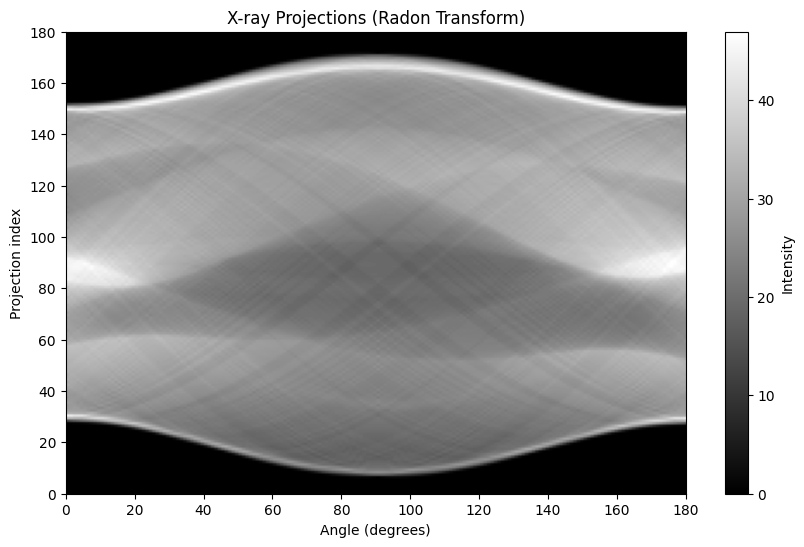

In [3]:
### 2.2 模拟 X 射线投影数据

# 选择投影角度
theta = np.arange(0, 180, 1)  # 从 0° 到 179°，每隔 1° 取一个角度

# 计算 Radon 变换（X 射线投影数据）
sinogram = radon(phantom, theta=theta)

# 可视化投影数据
plt.figure(figsize=(10, 6))
plt.imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
plt.title("X-ray Projections (Radon Transform)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Projection index")
plt.colorbar(label='Intensity')
plt.show()

Text(0.5, 1.0, 'BP Reconstruction')

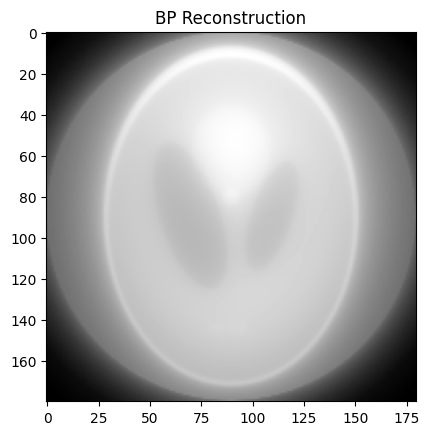

In [4]:
###3.1 反投影重建 (N = 180)
def IRandonTransform(image, steps):
    # 定义用于存储重建后的图像的数组
    channels = len(image[0])
    origin = np.zeros((steps, channels, steps))
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueExpandDim = np.expand_dims(projectionValue, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(
            projectionValueRepeat, i * 180 / steps, reshape=False
        ).astype(np.float64)
    # 各个投影角度的投影值已经都保存在origin数组中，只需要将它们相加即可
    iradon = np.sum(origin, axis=0)
    return iradon

iradon = IRandonTransform(P, P.shape[0])
plt.figure()
plt.imshow(iradon, cmap="gray")
plt.title("BP Reconstruction")

180


C:\Users\18148\AppData\Local\Temp\ipykernel_16056\1212324044.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  filterRL[i] = -1.0 / np.power((i - N / 2) * np.pi * d, 2.0)


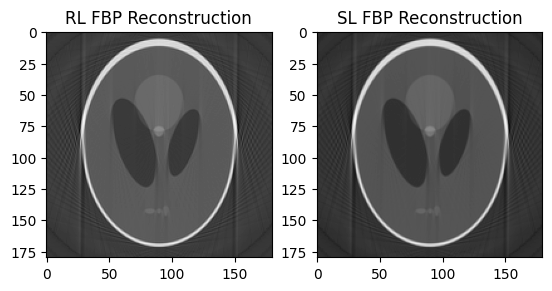

In [5]:
### 3.2 基于滤波反投影的方法

# 1）两种滤波器的实现
# Ram - Lak 滤波器
def RLFilter(N, d):
    filterRL = np.zeros((N,))
    for i in range(N):
        filterRL[i] = -1.0 / np.power((i - N / 2) * np.pi * d, 2.0)
        if np.mod(i - N / 2, 2) == 0:
            filterRL[i] = 0
    filterRL[int(N / 2)] = 1 / (4 * np.power(d, 2.0))
    return filterRL

# Shepp - Logan 滤波器
def SLFilter(N, d):
    filterSL = np.zeros((N,))
    for i in range(N):
        # filterSL[i] = - 2 / (np.power(np.pi, 2.0) * np.power(d, 2.0) * (np.power((4 * (i - N / 2)), 2.0) - 1))
        filterSL[i] = -2 / (np.pi**2.0 * d**2.0 * (4 * (i - N / 2) ** 2.0 - 1))
    return filterSL

# 2）定义用于存储重建后的图像的数组
#channels = 512
def RL_Transform(image, steps):
    channels = len(image[0])
    print(channels)
    origin = np.zeros((steps, channels, channels))
    # filter = RLFilter(channels, 1)
    filter = RLFilter(channels, 1)
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueFiltered = convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(
            projectionValueRepeat, i * 180 / steps, reshape=False
        ).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    return iradon


def SL_Transform(image, steps):
    channels = len(image[0])
    origin = np.zeros((steps, channels, channels))
    # filter = RLFilter(channels, 1)
    filter = SLFilter(channels, 1)
    for i in range(steps):
        projectionValue = image[:, i]
        projectionValueFiltered = convolve(filter, projectionValue, "same")
        projectionValueExpandDim = np.expand_dims(projectionValueFiltered, axis=0)
        projectionValueRepeat = projectionValueExpandDim.repeat(channels, axis=0)
        origin[i] = ndimage.rotate(
            projectionValueRepeat, i * 180 / steps, reshape=False
        ).astype(np.float64)
    iradon = np.sum(origin, axis=0)
    return iradon


RL = RL_Transform(P, len(P[0]))
SL = SL_Transform(P, len(P[0]))
# 对图像进行上下翻转
# RL_flipped = np.flipud(RL)
# SL_flipped = np.flipud(SL)
# 绘制原始图像和对应的sinogram图
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(RL, cmap="gray")
plt.title("RL FBP Reconstruction")
plt.subplot(1, 2, 2)
plt.imshow(SL, cmap="gray")
plt.title("SL FBP Reconstruction")
plt.show()


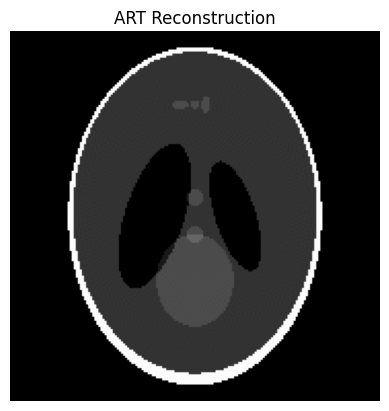

In [6]:
# 3.2 ART重建算法
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan
from skimage.transform import radon, iradon

# 系统设置
N = 180
ANG = 180
VIEW = 360
THETA = np.linspace(0, ANG, VIEW + 1)[:-1]

# 定义线性变换 A 和其转置 AT
A = lambda x: radon(x, THETA, circle=False).astype(np.float32)
AT = lambda y: iradon(y, THETA, circle=False, output_size=N).astype(np.float32) / (np.pi / (2 * len(THETA)))

# 生成投影数据
p = A(phantom)

# 添加噪声（可选，用于模拟低剂量情况）
# 可以根据需求添加噪声，这里我们保持简单
# noise_level = 0.1
# p += noise_level * np.random.normal(size=p.shape)

# ART 重建函数
def ART(A, AT, b, x, mu=1e0, niter=100, bpos=True):
    ATA = AT(A(np.ones_like(x)))

    for i in range(int(niter)):
        x = x + np.divide(mu * AT(b - A(x)), ATA)

        if bpos:
            x[x < 0] = 0

        # # 实时显示重建进程
        # plt.imshow(x, cmap='gray')
        # plt.title("%d / %d" % (i + 1, niter))
        # plt.axis('off')
        # plt.pause(0.1)  # 暂停以显示图像
        # plt.close()

    return x

# 初始化重建图像
x0 = np.zeros_like(phantom)

# 使用 ART 进行重建
x_art = ART(A, AT, p, x0, mu=1e0, niter=200)

# 显示重建结果
plt.imshow(x_art, cmap='gray')
plt.title("ART Reconstruction")
plt.axis('off')
plt.show()